# 1. Preprocessing

### 1.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn import preprocessing , utils

### 1.2 Dataset Metadata 

- Note: The data came without headers, so i checked on the UCI website and named them accordenly

- Reading the dataset and naming the columns

In [60]:
data = pd.read_csv("data/abalone.data" , sep = "," , header= None)

In [61]:
data.columns = ["sex" , "length" , "diameter" , "height" , "whole_weight" , "shucked_weight",
               "viscera_weight" , "shell_weight" , "rings"]

- Glimspe at the dataset, and checking the dimenstions

In [4]:
print(f"The dataset have {data.shape[0]} rows and {data.shape[1]} columns")
data.head()

The dataset have 4177 rows and 9 columns


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


- The dataset is pretty small, only 4177 rows without checking yet for duplication

- Information about the columns - number of NA and type of each column.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


- All except the "sex" column are numeric
- We dont have any NA in the dataset - great!

- Checking the number of unique instances for each variable to get a hint if we have duplicate instances

In [20]:
data.nunique()

sex                  3
length             134
diameter           111
height              51
whole_weight      2429
shucked_weight    1515
viscera_weight     880
shell_weight       926
rings               28
dtype: int64

- Considering the variables are mostly numeric, it is odd to see that even the most diverse variable - the "whole_weight" is only half of the total instances. Thus we will check with df.duplicated() to make sure
- We have 28 different levels in our target - "rings"
- The feature "sex" have 3 categories, with the extra one is "I" which is "infant"

- Checking the number of duplicated instances

In [21]:
data.duplicated().sum()

0

- Great, we don't have any duplicated rows! 

- __Thus we conclude the metadata section - we checked for NA, the types of our columns, the shape of our dataset and made sure we don't have any duplicates.__

### 1.3 EDA

- __In this section we will perform EDA on out dataset, using statistics, plots and tables__

### 1.3.1 Univirate analasys

#### 1.3.1.1 Target variable

- First, we will check the distribuion of "rings" - the variable that we want to predict

In [6]:
data.groupby("rings" , as_index=False).agg(count = ("rings" , "count") , 
                                          pct = ("rings" , lambda x: x.count() / data["rings"].size))\
.sort_values("count" , ascending=False).reset_index(drop = True)

,rings,count,pct
0,9,689,0.164951
1,10,634,0.151784
2,8,568,0.135983
3,11,487,0.116591
4,7,391,0.093608
5,12,267,0.063921
6,6,259,0.062006
7,13,203,0.048599
8,14,126,0.030165
9,5,115,0.027532


- Right away we can see the target is very imbalanced, with few levels that have only 1 instance

[Text(0.5, 1.0, 'Boxplot of Rings'), Text(0.5, 0, 'Number of Rings')]

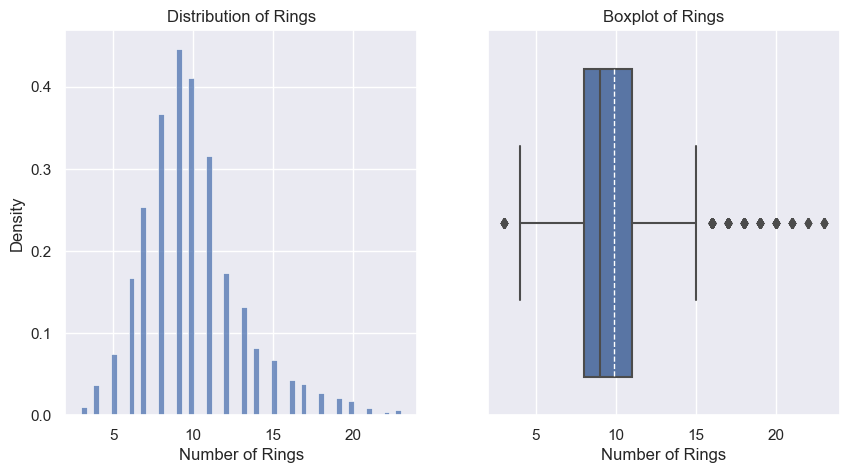

In [43]:
sns.set_theme()
f , ax = plt.subplots(1,2 , figsize = (10,5) , sharex=False , sharey=False)
sns.histplot(data = data , x="rings" , ax = ax[0] , stat = "density")\
.set(title = "Distribution of Rings" , xlabel = "Number of Rings" , ylabel = "Density")
sns.boxplot(data=data , x = "rings" , ax = ax[1] , showmeans = True , meanline = True , meanprops = {"color" : "white"})\
.set(title = "Boxplot of Rings" , xlabel = "Number of Rings")

- We got major problem - the target variable which we want to classify is extremly imbalanced. We will use SMOTE algorithm for up-sampling our target levels. But because the algo use KNN for creating synthetic points, it needs more than 1 neighbour. Becuase of this reason, we will completly drop the levels that have 2 or less instances - meaning the levels (27,24,26,1,25,2,29). With SMOTE we will up-sample all the levels that are under 100 instances to 100
- We will drop the levels now, so their 1-2 instances won't intervine with our next plots and statistics
- Also notice we don't have the level 28 in our levels, with regard to the sparity in the larger rings this is probably normal
- __Important note__: We will use SMOTE only after(!) splitting the dataset to train and test, that is because if we didn't to that we will have synthetic instances in our test data, and their not real

In [62]:
data.drop(data[(data.rings < 3) | (data.rings > 23)].index , inplace=True)

#### 1.3.1.2 Numeric Variables

In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,4168.0,0.523978,0.119751,0.1100,0.450000,0.54500,0.6150,0.8150
diameter,4168.0,0.407849,0.098961,0.0900,0.350000,0.42500,0.4800,0.6500
height,4168.0,0.139473,0.041707,0.0000,0.115000,0.14000,0.1650,1.1300
whole_weight,4168.0,0.827825,0.489297,0.0080,0.441500,0.79925,1.1510,2.8255
shucked_weight,4168.0,0.359232,0.221845,0.0025,0.186000,0.33575,0.5015,1.4880
viscera_weight,4168.0,0.180502,0.109538,0.0005,0.093375,0.17050,0.2525,0.7600
shell_weight,4168.0,0.238377,0.138419,0.0030,0.130000,0.23325,0.3275,1.0050
rings,4168.0,9.910749,3.153493,3.0000,8.000000,9.00000,11.0000,23.0000


- Most of the features have mean and median pretty close, suggesting that they have normal distribuion
- We have "height" instances where the minimum is 0, which is rather strange. We will look at it now

In [9]:
data[data["height"] == 0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


- Considering that we have only 2 instances of "height" 0, and the number of rings is levels that we have many instances of, we will drop this 2 from the dataset

In [63]:
data.drop(data[data["height"] == 0].index , axis = 0 , inplace = True)

- Other than that, we don't have any more analasys of the describe table
- We will plot the density of all features in order to see if they indeed normal distirbuted

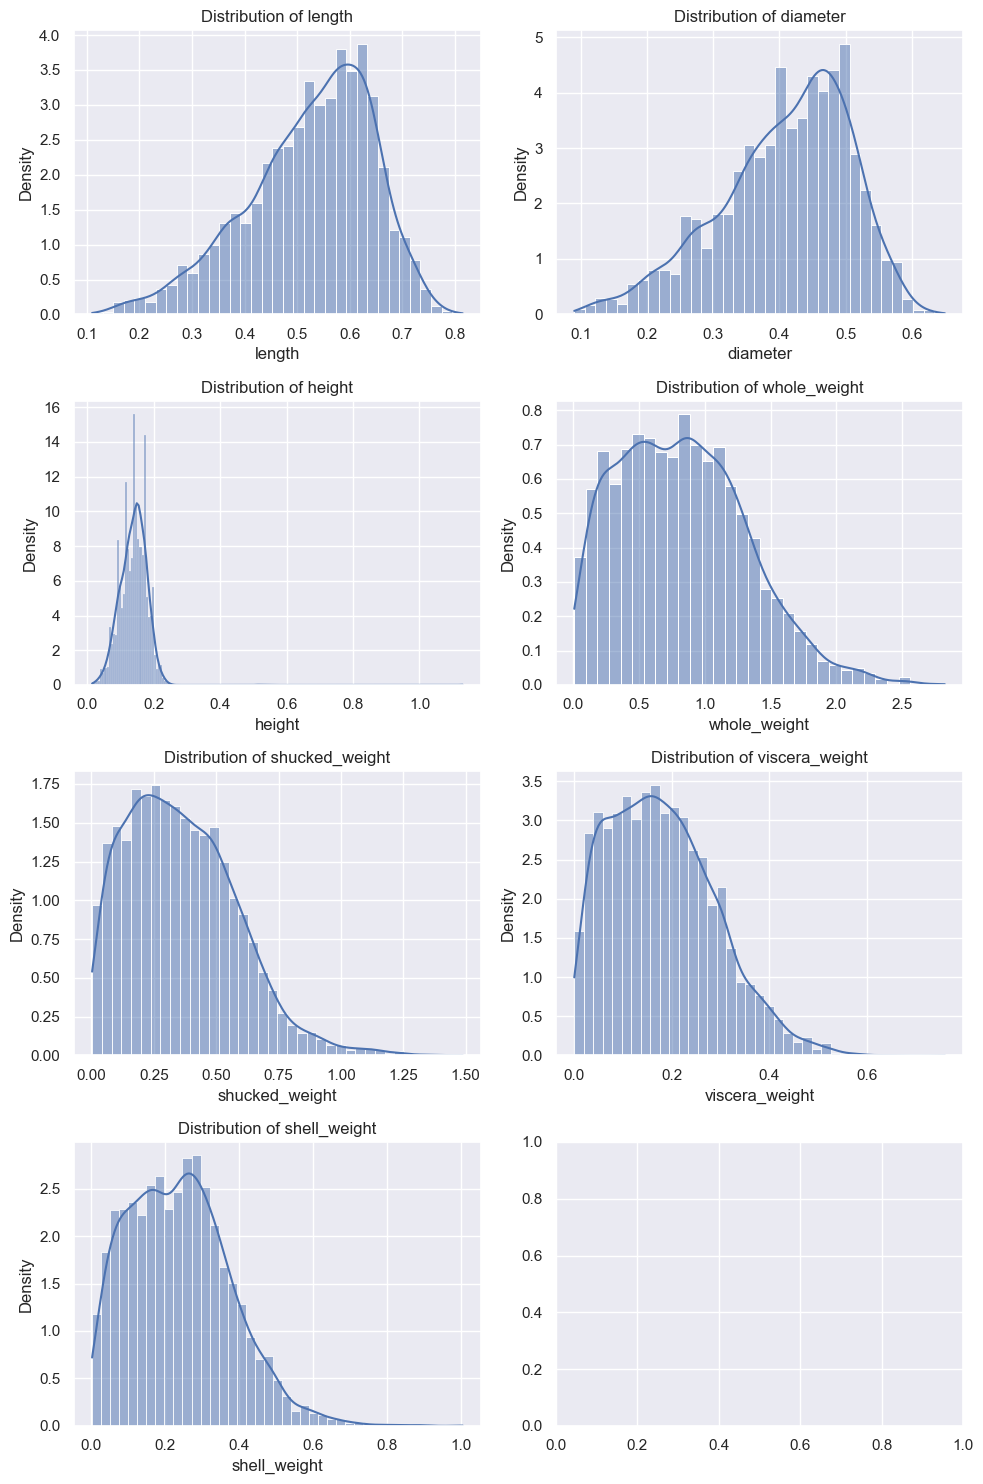

In [66]:
f , ax = plt.subplots(4,2 , figsize = (10,15) , sharex=False , sharey=False)

sns.histplot(data = data , x= "length" , ax = ax[0,0] , stat = "density" , kde=True)\
.set(title = "Distribution of length" , xlabel = "length" , ylabel = "Density")

sns.histplot(data = data , x= "diameter" , ax = ax[0,1] , stat = "density", kde=True)\
.set(title = "Distribution of diameter" , xlabel = "diameter" , ylabel = "Density")

sns.histplot(data = data , x= "height" , ax = ax[1,0] , stat = "density", kde=True)\
.set(title = "Distribution of height" , xlabel = "height" , ylabel = "Density")

sns.histplot(data = data , x= "whole_weight" , ax = ax[1,1] , stat = "density", kde=True)\
.set(title = "Distribution of whole_weight" , xlabel = "whole_weight" , ylabel = "Density")

sns.histplot(data = data , x= "shucked_weight" , ax = ax[2,0] , stat = "density", kde=True)\
.set(title = "Distribution of shucked_weight" , xlabel = "shucked_weight" , ylabel = "Density")

sns.histplot(data = data , x= "viscera_weight" , ax = ax[2,1] , stat = "density", kde=True)\
.set(title = "Distribution of viscera_weight" , xlabel = "viscera_weight" , ylabel = "Density")

sns.histplot(data = data , x= "shell_weight" , ax = ax[3,0] , stat = "density", kde=True)\
.set(title = "Distribution of shell_weight" , xlabel = "shell_weight" , ylabel = "Density")

f.tight_layout()

- We can see from the plots that only length, diameter and height are pretty normally distributed, and all of the other features are slight right leaning skewed. But becuase all the features are very close to zero, we cant apply log transformation which probably make them very left skewed with large negative values
- Furthermore, those "outliers" are probably have large correlation with the target variable, so we will pay attention to that in the next sections

#### 1.3.1.3 Categorical variables

- The only feature that is categorical in our dataset is the "sex" feature

<AxesSubplot: xlabel='sex', ylabel='count'>

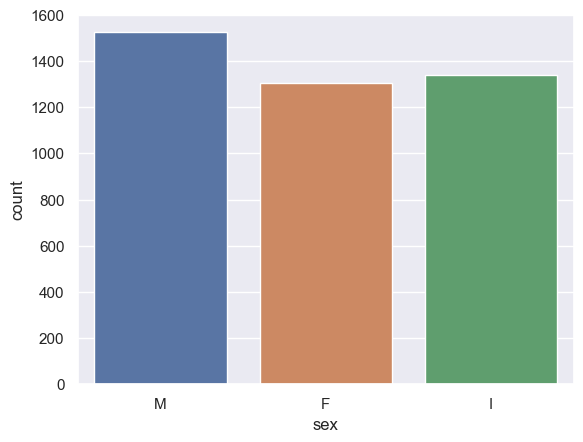

In [67]:
sns.countplot(data = data , x = "sex")

- We can see that the feature is well balanced, with sufficient number of instances for each level

### 1.3.2 Bivirate analasys

In [8]:
dataset , targets = data.iloc[: , :-1] , data["rings"]

<AxesSubplot: >

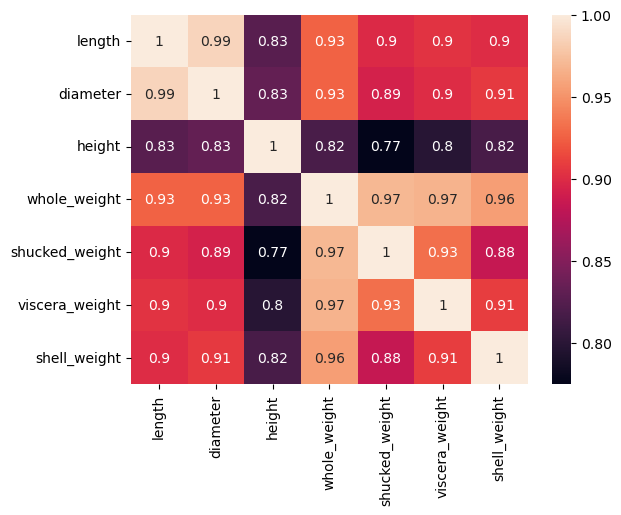

In [9]:
sns.heatmap(dataset.corr(numeric_only=True) , annot=True)

- distribution of features for each type of sex
- number of instances for each type of sex
- balance targets 

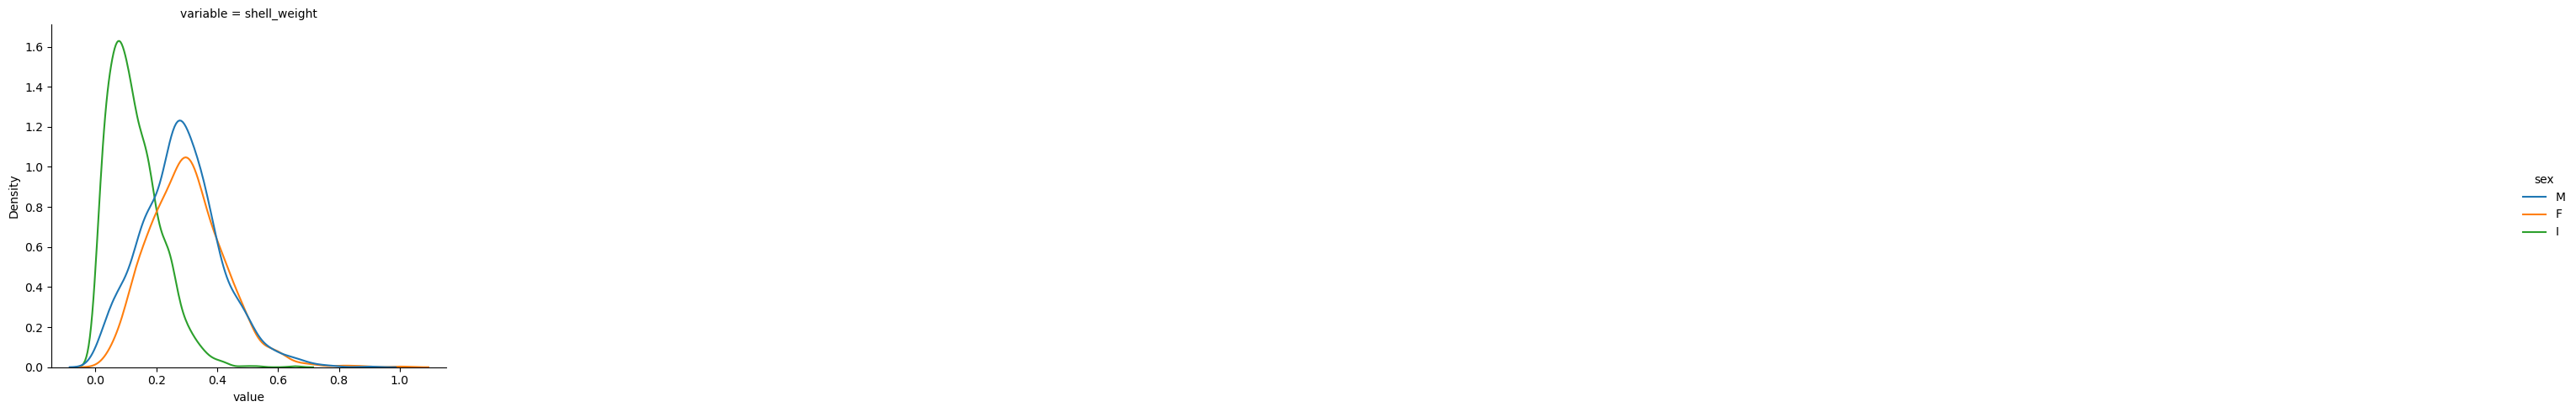

In [62]:
features = dataset.columns[(dataset.columns != "sex") & (dataset.columns != "whole_weight")]
dfm = dataset.melt(id_vars='sex', value_vars= features.to_list)
sns.displot(kind='kde', data=dfm, col='variable', col_wrap=6, x='value', hue='sex', facet_kws={'sharey': False, 'sharex': False})

list

In [46]:
dataset[["sex_I" , "sex_M"]] = pd.get_dummies(dataset["sex"] , drop_first=True)
dataset.drop('sex' , axis=  1 , inplace=True)

In [59]:
targets_to_sample = (targets.groupby(targets).count() < 100)
targets_to_sample = targets_to_sample[targets_to_sample == True].index
targets_to_sample_dict = {t:100 for t in targets_to_sample}

In [64]:
oversample = imblearn.over_sampling.SMOTE(random_state=42 , k_neighbors=5 , sampling_strategy=targets_to_sample_dict)
X_train , y_train = oversample.fit_resample(dataset , targets)

In [74]:
print(X_train.iloc[-10: ,:])
print(y_train.iloc[-10:])

        length  diameter    height  whole_weight  shucked_weight  \
4832  0.604405  0.461744  0.196789      1.187981        0.368983   
4833  0.535626  0.407813  0.138593      0.777755        0.287387   
4834  0.459418  0.382898  0.164276      0.816645        0.250217   
4835  0.532131  0.407342  0.147764      0.796698        0.276217   
4836  0.608637  0.488709  0.150143      1.098903        0.422510   
4837  0.566944  0.428313  0.150734      0.884046        0.321122   
4838  0.613279  0.499836  0.174590      1.129393        0.409590   
4839  0.541657  0.411424  0.140960      0.785131        0.289962   
4840  0.620000  0.481882  0.205941      1.215519        0.380287   
4841  0.497334  0.394564  0.161359      0.817228        0.251092   

      viscera_weight  shell_weight  sex_I  sex_M  
4832        0.262799      0.419405      0      0  
4833        0.169657      0.255209      0      0  
4834        0.186356      0.270071      0      0  
4835        0.167257      0.280422      0      